### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
import os
import numpy as np
import pandas as pd
import mlflow
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [2]:
# 2.1 Загрузка данных
db_host = os.getenv("DB_DESTINATION_HOST")
db_port = os.getenv("DB_DESTINATION_PORT")
db_user = os.getenv("DB_DESTINATION_USER")
db_password = os.getenv("DB_DESTINATION_PASSWORD")
db_name = os.getenv("DB_DESTINATION_NAME")

TABLE_NAME = "clean_realestate_data"

engine = create_engine(
    f"postgresql+psycopg://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", engine)

In [3]:
# 2.2. Общий обзор датасета
df

,id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price
0,6061,2009,2,55.666611,37.584793,2.70,310,16,1,2,0,10.0,28.799999,2,0,60.799999,17500000.0
1,6062,1967,4,55.867245,37.538700,2.64,281,9,1,7,0,6.0,33.700001,3,0,51.000000,11150000.0
2,6063,1978,4,55.780266,37.827213,2.64,381,12,1,9,0,9.0,30.500000,2,0,52.200001,10000000.0
3,6064,1998,4,55.651772,37.769936,2.64,361,16,1,11,0,9.0,32.000000,2,0,53.900002,11800000.0
4,6065,1970,4,55.883766,37.710735,2.48,144,9,1,4,0,5.9,27.700001,2,0,44.400002,8300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117284,41861,2017,2,55.627266,37.342426,3.00,480,9,1,3,0,13.0,0.000000,1,0,42.000000,12700000.0
117285,41863,1959,1,55.705063,37.669018,3.00,138,9,1,5,0,9.0,31.900000,2,0,53.099998,13750000.0
117286,41864,2015,2,55.569714,37.490391,2.74,307,16,1,16,0,15.7,35.000000,2,0,67.099998,14700000.0
117287,41865,1996,4,55.835365,37.355812,2.64,203,17,1,1,0,10.5,0.000000,2,0,56.000000,15500000.0


In [3]:
X = df.drop(columns=["id"])
y = df["price"]

In [5]:
X.describe()

,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price
count,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.000000,117289.0,117289.000000,1.172890e+05
mean,1985.204674,3.489603,55.726303,37.602137,2.693449,250.482321,13.583183,0.897851,7.148855,0.007810,8.180470,27.549481,1.948623,0.0,52.082145,1.196442e+07
std,19.812262,1.406183,0.103461,0.148062,0.134221,193.135109,5.904842,0.302846,5.177543,0.088028,3.065166,14.699228,0.818084,0.0,16.541026,4.651179e+06
min,1902.000000,0.000000,55.427238,37.192894,2.450000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,11.000000,1.100000e+01
25%,1969.000000,2.000000,55.646229,37.495258,2.640000,119.000000,9.000000,1.000000,3.000000,0.000000,6.000000,19.000000,1.000000,0.0,38.500000,8.600000e+06
50%,1981.000000,4.000000,55.715607,37.589546,2.640000,204.000000,14.000000,1.000000,6.000000,0.000000,8.500000,28.500000,2.000000,0.0,49.599998,1.099000e+07
75%,2004.000000,4.000000,55.812176,37.718803,2.740000,321.000000,17.000000,1.000000,10.000000,0.000000,10.000000,36.099998,3.000000,0.0,61.299999,1.420000e+07
max,2023.000000,6.000000,56.011032,37.946411,3.000000,4455.000000,99.000000,1.000000,55.000000,1.000000,16.300000,75.000000,7.000000,0.0,121.000000,2.900000e+07


In [6]:
y.describe()

count    1.172890e+05
mean     1.196442e+07
std      4.651179e+06
min      1.100000e+01
25%      8.600000e+06
50%      1.099000e+07
75%      1.420000e+07
max      2.900000e+07
Name: price, dtype: float64

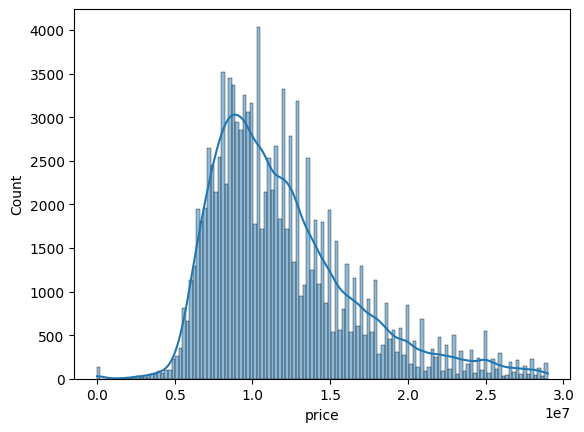

In [33]:
sns.histplot(y, kde=True)
plt.show()

Можно рассмотреть признак цены за квадратный метр в качестве доп. признака

In [4]:
X['price_per_m2'] = y / X['total_area']

In [8]:
# 2.3 Анализ признаков для модели
X.isnull().sum()

build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
studio               0
total_area           0
price                0
price_per_m2         0
dtype: int64

In [36]:
X.dtypes

build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator           int64
floor                  int64
is_apartment           int64
kitchen_area         float64
living_area          float64
rooms                  int64
studio                 int64
total_area           float64
price                float64
price_per_m2         float64
dtype: object

In [38]:
corr = X.corr()

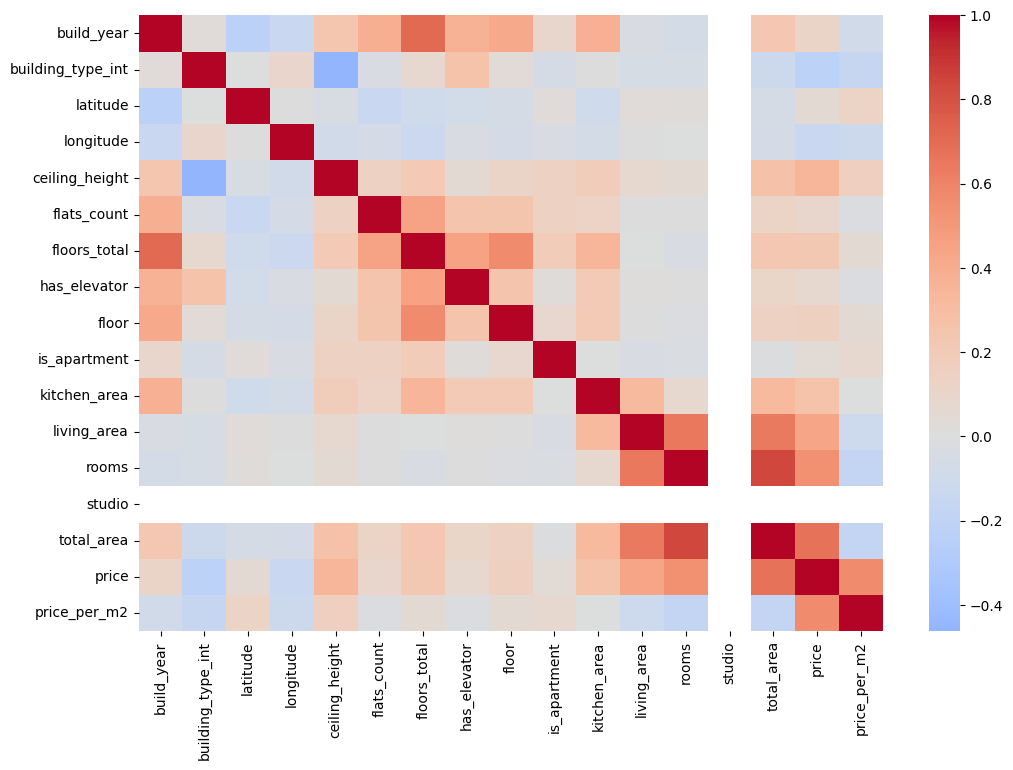

In [39]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

Наблюдается умеренная корреляция между рядом признаков и переменными living_room и floors_total, поэтому стоит рассмотреть возможность их исключения, чтобы снизить влияние мультиколлинеарности

In [5]:
X.drop(columns=["floors_total", "living_area"], inplace=True)

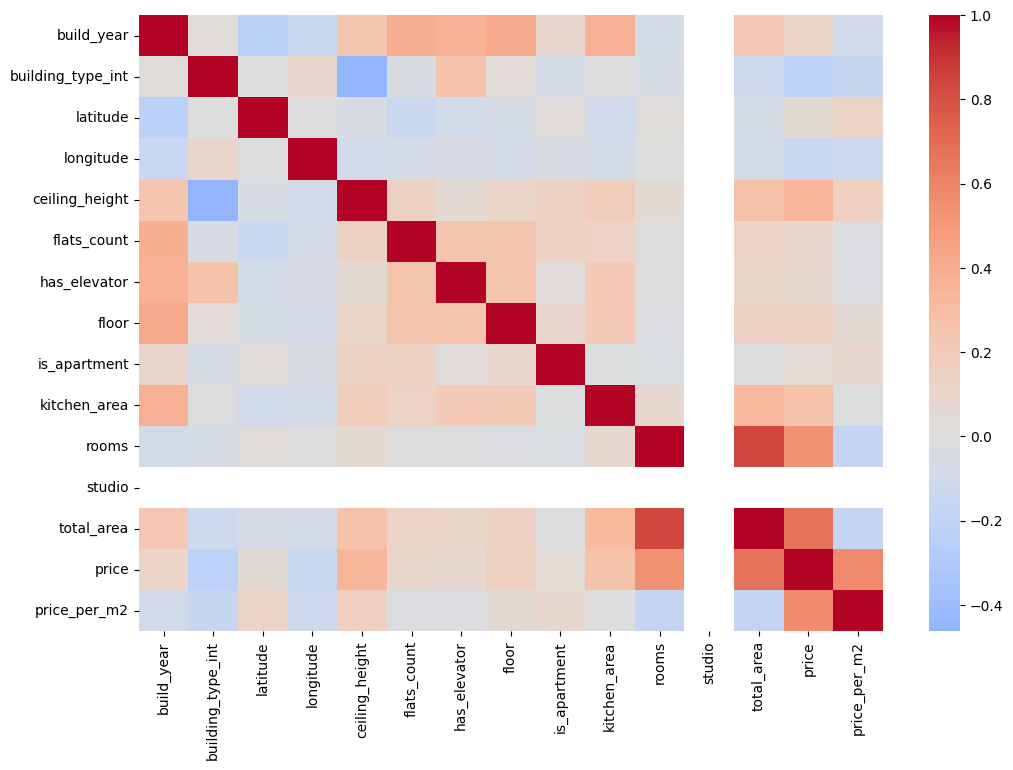

In [41]:
corr = X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

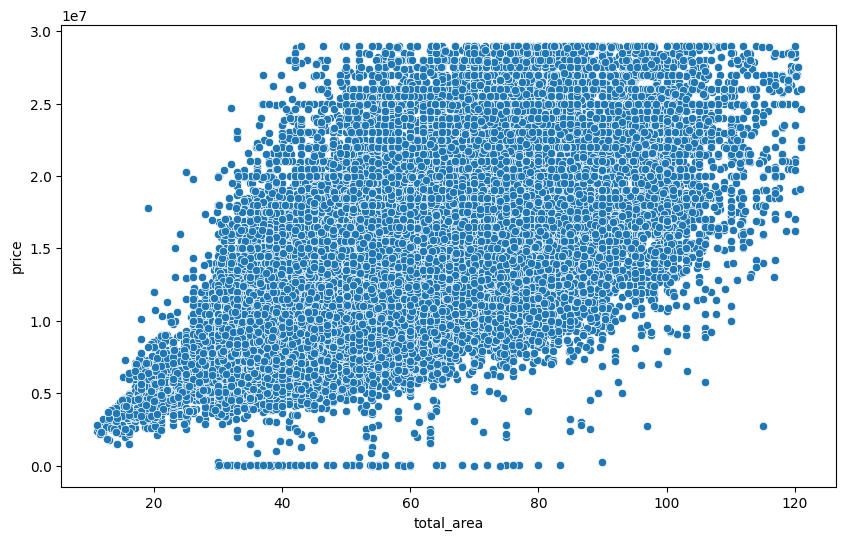

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X["total_area"], y=y, data=X)
plt.show()

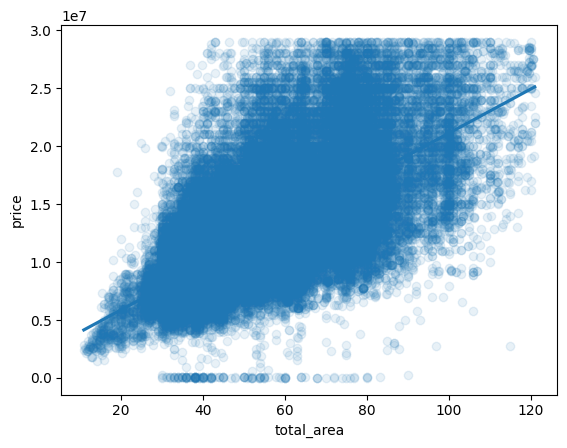

In [ ]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков
sns.regplot(x='total_area', y='price', data=X, scatter_kws={'alpha': 0.1})
plt.show()

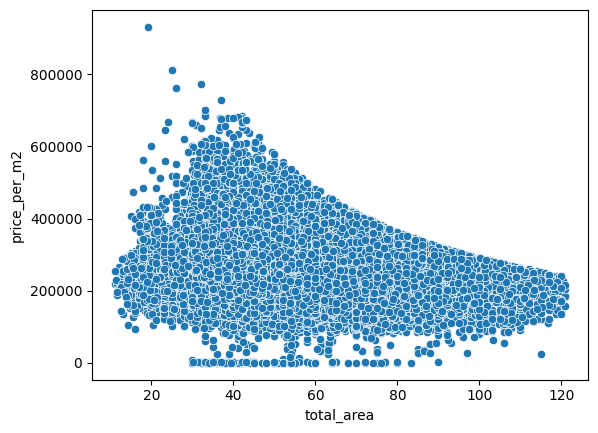

In [49]:
sns.scatterplot(x='total_area', y='price_per_m2', data=X)
plt.show()

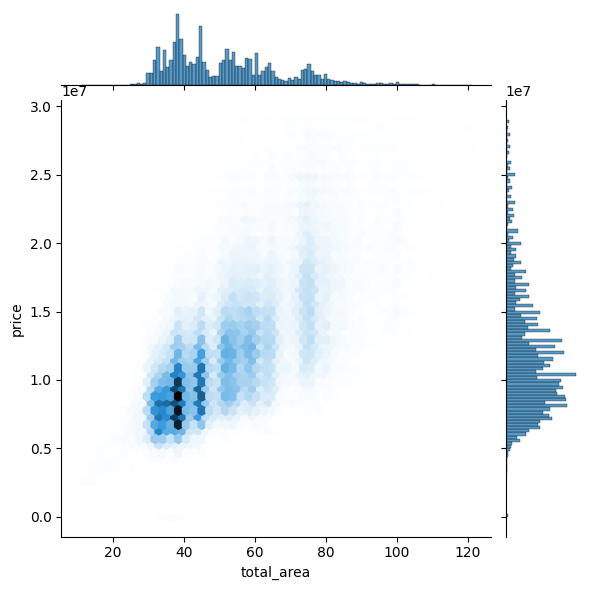

In [51]:
sns.jointplot(x='total_area', y='price', data=X, kind='hex')
plt.show()

In [ ]:
# 2.5 Выводы после EDA
""" 
В целом данных у нас достаточно — 117 289 примеров.
Целевая переменная price имеет линейную зависимость от общей площади. Тем не менее, для цены за квадратный метр линейная зависимость не наблюдается.
Большинство наблюдений по площади находится в диапазоне от 30 до 70 м².
Разброс значений небольшой.
В целом, чем больше общая площадь, тем выше цена, но тем ниже стоимость за квадратный метр.
"""

В целом данных у нас достаточно — 117 289 примеров.
Целевая переменная price имеет линейную зависимость от общей площади. Тем не менее, для цены за квадратный метр линейная зависимость не наблюдается.
Большинство наблюдений по площади находится в диапазоне от 30 до 70 м².
Разброс значений небольшой.
В целом, чем больше общая площадь, тем выше цена, но тем ниже стоимость за квадратный метр.

In [ ]:
with open("report.md", 'w') as f:
    f.write("# EDA summary \n")
    f.write("""
            - Можно рассмотреть признак цены за квадратный метр в качестве доп. признака
            - Наблюдается умеренная корреляция между рядом признаков и переменными living_room и floors_total, поэтому стоит рассмотреть возможность их исключения, чтобы снизить влияние мультиколлинеарности
            - В целом данных у нас достаточно — 117 289 примеров.
            - Целевая переменная price имеет линейную зависимость от общей площади. Тем не менее, для цены за квадратный метр линейная зависимость не наблюдается.
            Большинство наблюдений по площади находится в диапазоне от 30 до 70 м².
            Разброс значений небольшой.
            В целом, чем больше общая площадь, тем выше цена, но тем ниже стоимость за квадратный метр.
""")

In [6]:
# 2.6 логирование артефактов в MLflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_linear_model"
RUN_NAME = "EDA_summary"
REGISTRY_MODEL_NAME = "Registered_Linear_model"

In [7]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [8]:
os.environ["MLFLOW_S3_ENDPOINT_URL"]="https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"]=os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"]=os.getenv("AWS_SECRET_ACCESS_KEY")

In [58]:
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [63]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("project_template_sprint_2.ipynb", artifact_path="notebooks")
    mlflow.log_artifact("report.md", artifact_path="reports")

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [9]:
# 3.1 ручная генерация признаков
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from autofeat import AutoFeatRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [10]:
X = X.drop(columns=["price"])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
poly_encoder = PolynomialFeatures(degree=2)
kbin_encoder = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='quantile')

In [13]:
afreg = AutoFeatRegressor(feateng_steps=1 , featsel_runs=5)

In [14]:
preprocessor = ColumnTransformer(transformers=[
    ("polynomial", poly_encoder, ["total_area", "price_per_m2"]),
    ("kbins", kbin_encoder, ["build_year", "latitude", "longitude"]),
    ("autofeat", afreg, ["flats_count", "rooms"])
],
remainder='drop',
verbose_feature_names_out=False)

In [ ]:
# 3.4 обучение новой версии модели

In [72]:
model = LinearRegression()

In [73]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [74]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('polynomial',
                                                  PolynomialFeatures(),
                                                  ['total_area',
                                                   'price_per_m2']),
                                                 ('kbins',
                                                  KBinsDiscretizer(n_bins=4),
                                                  ['build_year', 'latitude',
                                                   'longitude']),
                                                 ('autofeat',
                                                  AutoFeatRegressor(feateng_steps=1),
                                                  ['flats_count', 'rooms'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [75]:
prediction = pipeline.predict(X_test)

In [76]:
r2 = r2_score(y_test, prediction)
MAE = mean_absolute_error(y_test, prediction)

In [77]:
metrics = {}
metrics["r2"] = r2
metrics["mae"] = MAE


In [ ]:
# 3.5 логирование артефактов в MLflow

In [131]:
RUN_NAME = "feature_generating"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run = run.info.run_id
    mlflow.log_metrics(metrics)
    model_info = mlflow.sklearn.log_model(sk_model=pipeline,
                                          artifact_path="models",
                                          registered_model_name=REGISTRY_MODEL_NAME,
                                          )

Registered model 'Registered_Linear_model' already exists. Creating a new version of this model...
2026/01/30 06:17:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Registered_Linear_model, version 2
Created version '2' of model 'Registered_Linear_model'.


#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [85]:
# 4.1 Отбор признаков при помощи метода номер 1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [16]:
model = LinearRegression()

In [17]:
sbs = SFS(model, k_features=10, forward=False, floating=False, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

In [18]:
sbs = sbs.fit(X_train, y_train)

In [19]:
sbs.k_feature_idx_

(0, 2, 4, 5, 6, 7, 8, 9, 12, 13)

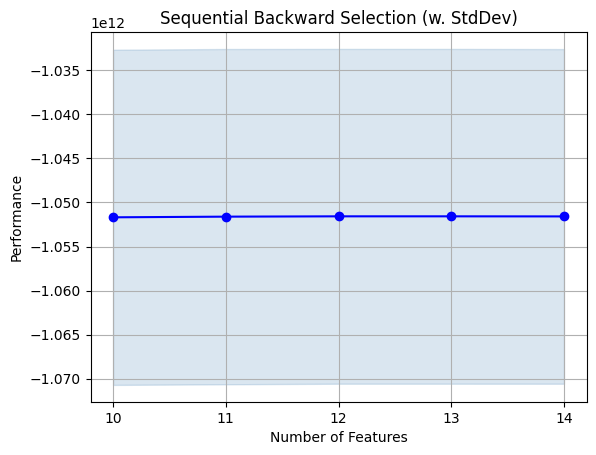

In [92]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind="std_dev")
plt.title("Sequential Backward Selection (w. StdDev)")
plt.grid()
plt.show()

In [93]:
os.makedirs("fs_assets", exist_ok=True)
plt.savefig(f"fs_assets/sbs.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [20]:
sfs = SFS(model, k_features=10, forward=True, floating=False, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

In [21]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=3, estimator=LinearRegression(),
                          k_features=(10, 10), n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [22]:
sfs.k_feature_idx_

(0, 2, 4, 5, 6, 7, 8, 9, 12, 13)

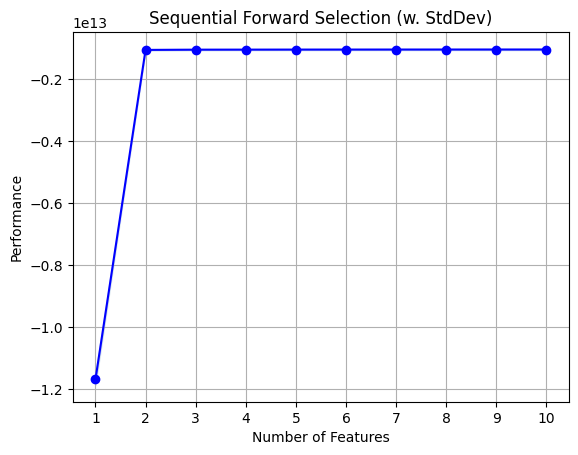

In [88]:
fig2 = plot_sfs(sfs.get_metric_dict(), kind="std_dev")
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()

In [91]:
os.makedirs("fs_assets", exist_ok=True)
plt.savefig(f"fs_assets/sfs.png")

<Figure size 640x480 with 0 Axes>

Оба метода отобрали одинаковые признаки.

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [23]:
union_index = set(list(sfs.k_feature_idx_)).union(set(list(sbs.k_feature_idx_)))

In [24]:
union_index

{0, 2, 4, 5, 6, 7, 8, 9, 12, 13}

In [25]:
selected_columns  = X_train.columns[list(union_index)]

In [26]:
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

In [ ]:
# 4.4 Обучение новой версии модели

In [70]:
model.fit(X_train_selected, y_train)

LinearRegression()

In [80]:
accuracy = model.score(X_test_selected, y_test)

In [82]:
predictions = model.predict(X_test_selected)

In [83]:
r2 = r2_score(y_test, predictions)

In [85]:
mae = mean_absolute_error(y_test, predictions)

In [87]:
metrics = {
    "r2": r2,
    "mae": mae
}

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

In [96]:
RUN_NAME = "SFS_selected_model"
pip_requirements ="../requirements.txt"
signature = mlflow.models.infer_signature(X_test, predictions)
input_example = X_test_selected[:10]

/home/mle-user/mle_projects/mle-project-sprint-2/.venv_sprint_2/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


In [92]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [97]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics)
    molel_info = mlflow.sklearn.log_model(sk_model=model,
                                          artifact_path="models",
                                          registered_model_name=REGISTRY_MODEL_NAME,
                                          pip_requirements=pip_requirements,
                                          signature=signature,
                                          input_example=input_example
                                          )

2026-01-30 12:10:22,058 INFO: Found credentials in environment variables.
Registered model 'Registered_Linear_model' already exists. Creating a new version of this model...
2026/01/30 12:10:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Registered_Linear_model, version 3
Created version '3' of model 'Registered_Linear_model'.


### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [45]:
import optuna
from optuna.integration import MLflowCallback
from sklearn.model_selection import cross_val_score, GridSearchCV

In [37]:
STUDY_NAME = "Search_by_optuna"
STORAGE = "sqlite:///optuna_db.db"

In [67]:
def objective(trial) -> float:
    params = {
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False]),
    }
    model = LinearRegression(**params)

    score = cross_val_score(
        model,
        X_train_selected,
        y_train,
        scoring="r2"
    )

    return np.mean(score)

In [48]:
EXPERIMENT_NAME = "final_model_hyperparms"
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [68]:
mlfc = MLflowCallback(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
                      metric_name="r2",
                      create_experiment=False,
                      mlflow_kwargs={"experiment_id": experiment_id})

/tmp/ipykernel_1454/3796079086.py:1: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlfc = MLflowCallback(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",


In [69]:
study = optuna.create_study(direction="maximize", study_name=STUDY_NAME, storage=STORAGE, sampler=optuna.samplers.TPESampler(), load_if_exists=True)
study.optimize(objective, n_trials=10, callbacks=[mlfc])

[I 2026-01-31 03:35:06,585] Using an existing study with name 'Search_by_optuna' instead of creating a new one.


[I 2026-01-31 03:35:06,808] Trial 35 finished with value: 0.9513051545330728 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 35 with value: 0.9513051545330728.
[I 2026-01-31 03:35:07,157] Trial 36 finished with value: 0.9513051545330728 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 35 with value: 0.9513051545330728.
[I 2026-01-31 03:35:07,564] Trial 37 finished with value: 0.9513051545330728 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 35 with value: 0.9513051545330728.
[I 2026-01-31 03:35:08,045] Trial 38 finished with value: 0.9513051545330728 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 35 with value: 0.9513051545330728.
[I 2026-01-31 03:35:08,403] Trial 39 finished with value: 0.9513051545330728 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 35 with value: 0.9513051545330728.
[I 2026-01-31 03:35:08,820] Trial 40 finished with value: 0.9513051545

In [70]:
best_params = study.best_params
best_value = study.best_value
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")
print(f"Best value: {best_value}")

Number of finished trials: 45
Best params: {'fit_intercept': True, 'positive': False}
Best value: 0.9513051545330728


In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [63]:
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False],
}

In [71]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

In [72]:
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

In [73]:
print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший счет:", grid_search.best_score_)

Лучшие гиперпараметры: {'fit_intercept': True, 'positive': False}
Лучший счет: 0.9513051545330728


In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [74]:
best_params = grid_search.best_params_

In [ ]:
# 5.4 Обуение финальной версии модели

In [75]:
final_model = LinearRegression(**best_params)

In [76]:
final_model.fit(X_train_selected, y_train)

LinearRegression()

In [77]:
final_model.score(X_test_selected, y_test)

0.9533820460365965

In [80]:
prediction = final_model.predict(X_test_selected)

In [81]:
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

In [82]:
metrics = {
    "r2": r2,
    "mae": mae
}

In [ ]:
# 5.5 Логирование артефактов в MLflow

In [78]:
RUN_NAME = "FINAL_MODEL_RUN"

In [83]:
pip_requirements ="../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test_selected[:10]

/home/mle-user/mle_projects/mle-project-sprint-2/.venv_sprint_2/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


In [84]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(best_params)
    mlflow.log_metrics(metrics)
    final_model_info = mlflow.sklearn.log_model(sk_model=final_model,
                                                artifact_path="models",
                                                registered_model_name=REGISTRY_MODEL_NAME,
                                                pip_requirements=pip_requirements,
                                                signature=signature,
                                                input_example=input_example)


2026-01-31 04:04:48,353 INFO: Found credentials in environment variables.
Registered model 'Registered_Linear_model' already exists. Creating a new version of this model...
2026/01/31 04:04:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Registered_Linear_model, version 4
Created version '4' of model 'Registered_Linear_model'.
